# Bayesian Linear Regression

In this notebook was created by Martin Engqvist in 2021 with the goal to implement and test ideas for Bayesian linear regression models. Inspiration for the modified least squares was drawn from page 66 of the book "A Bayesian Tutorial" by By D. S. Sivia and J. Skilling (ISBN 978-0-19-856831-5). The use of basis functions (fixed non-linear functions of the input variables) was inspired by formula 3.2 from page 138 of the book "Pattern recognition" by C. M. Bishop (ISBN 978-1-4939-3843-8). Additional help with implementing the model in Pyro was drawn from http://pyro.ai/examples/bayesian_regression.html.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.
This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.
You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [14]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta
import math
import scipy

import random 

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
from pyro.nn import PyroModule
from pyro import param
from pyro.poutine import trace
from pyro import condition
from pyro.optim import Adam, ClippedAdam
from pyro.infer import SVI, Trace_ELBO, HMC, MCMC, NUTS
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, AutoContinuous, AutoGuide

import torch

from pprint import pprint


from tqdm import tqdm

from os.path import join, exists, basename

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# for CI testing
smoke_test = ('CI' in os.environ)
pyro.set_rng_seed(1)

assert issubclass(PyroModule[nn.Linear], nn.Linear)
assert issubclass(PyroModule[nn.Linear], PyroModule)

display('pyro version: {}'.format(pyro.__version__))

pyro.set_rng_seed(101)

'pyro version: 1.4.0'

## Linear models

### Setup function to generate data

In [2]:
def get_x(y):
    pieces = 5
    
    X = []
    for idx in range(pieces-1):
        X.append(random.uniform(0, y-sum(X)))
    X.append(y-sum(X))
                  
    # randomize the order
    random.shuffle(X)
                  
    # devide by the weights (since I know the "true" fuction)
    X = np.array(X) / np.array([1, 2, 3, 4, 5])
    
    return X.tolist()


def generate_data(n=20, ymin=10, ymax=100, sigma=5):
    X = []
    y = []
    stdevs = []
    
    for s in range(n):
        # sample y three times (to simulate measurements)
        mu = np.random.choice(np.arange(ymin, ymax))
        measured_y = pyro.sample('y', dist.Normal(torch.ones(3)*mu, torch.ones(3)*sigma))

        # add y and stdev to data
        y.append(measured_y.mean().item())
        stdevs.append(measured_y.std().item())

        # find X to match this y
        # y is a linear combination of x
        # lm = x1*1 + x2*2 + x3*3 + x4*4 + x5*5 + 2.5 = y
        X.append(get_x(mu-2.5))

    df = pd.DataFrame({'y':y, 'stdev':stdevs})
    df = df.join(pd.DataFrame(X, columns=['x{}'.format(i) for i in range(1, len(X[0])+1)]) )
    
    return df



data_filepath = join('data', 'linear_model_balanced.tsv')
if exists(data_filepath):
    df = pd.read_csv(data_filepath, sep='\t', index_col=0)
    
else:
    # A set of data with low error
    df_low = generate_data(n=30, ymin=5, ymax=100, sigma=5)

    # A set of data with high error
    df_high = generate_data(n=10, ymin=5, ymax=100, sigma=30)

    # combine
    df = df_low.append(df_high)

    # randomize 
    df = df.sample(frac=1).reset_index(drop=True)
    
    # save it
    df.to_csv(data_filepath, sep='\t')


# prepare splits
train, test = train_test_split(df, test_size=0.2, random_state=42)

X_train = train.drop(['y', 'stdev'], axis=1).to_numpy()
y_train = train.y.to_numpy()
stdev_train = train.stdev.to_numpy()

X_test = test.drop(['y', 'stdev'], axis=1).to_numpy()
y_test = test.y.to_numpy()
stdev_test = test.stdev.to_numpy()

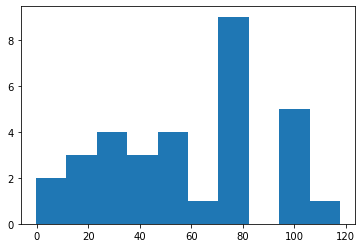

In [3]:
plt.hist(y_train)
plt.show()

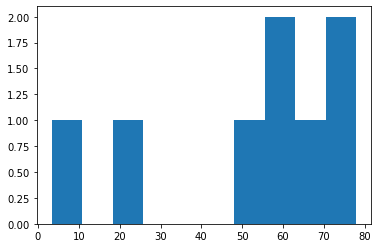

In [4]:
plt.hist(y_test)
plt.show()

## Fit a classical linear model

In [5]:
# data to tensor
X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train)
stdev_train = torch.tensor(stdev_train)

# Regression model
linear_reg_model_classical = PyroModule[torch.nn.Linear](X_train.shape[1], 1).double()

# Define loss and optimize
loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(linear_reg_model_classical.parameters(), lr=0.05)
num_iterations = 1500 if not smoke_test else 2

def train():
    # run the model forward on the data
    y_pred = linear_reg_model_classical(X_train).squeeze(-1)
    
    # calculate the mse loss
    loss = loss_fn(y_pred, y_train)
    
    # initialize gradients to zero
    optim.zero_grad()
    
    # backpropagate
    loss.backward()
    
    # take a gradient step
    optim.step()
    return loss

for j in range(num_iterations):
    loss = train()
    if j % 250 == 0:
        print("[iteration %04d] loss: %.4f" % (j, loss.item()))


# Inspect learned parameters
print("Learned parameters:")
for name, param in linear_reg_model_classical.named_parameters():
    print(name, param.data.numpy())

[iteration 0000] loss: 156297.1843
[iteration 0250] loss: 2992.9939
[iteration 0500] loss: 2968.4031
[iteration 0750] loss: 2962.3929
[iteration 1000] loss: 2958.2420
[iteration 1250] loss: 2955.7086
Learned parameters:
weight [[1.11545624 2.27797918 3.40071883 4.03587704 4.03920927]]
bias [1.03771337]


## Fit a classical linear model using a loss metric that accounts for measurement error
A robust linear model which accounts for the standard deviation in y when fitting. According to page 66 in "Data Analysis - A Bayesian Tutorial" (ISBN 978-0-19-856831-5).

In [6]:
# Regression model
linear_reg_model_errors = PyroModule[nn.Linear](X_train.shape[1], 1).double()

# Define loss and optimize
loss_fn = torch.nn.MSELoss(reduction='none')
optim = torch.optim.Adam(linear_reg_model_errors.parameters(), lr=0.05)
num_iterations = 1500 if not smoke_test else 2

def train():
    # run the model forward on the data
    y_pred = linear_reg_model_errors(X_train).squeeze(-1)
    
    # calculate the mse loss
    loss = loss_fn(y_pred, y_train)
    
    # for each sample, divide the loss by its measurement error
    loss = loss/stdev_train
        
    # sum
    loss = loss.sum()
    
    # initialize gradients to zero
    optim.zero_grad()
    
    # backpropagate
    loss.backward()
    
    # take a gradient step
    optim.step()
    return loss

for j in range(num_iterations):
    loss = train()
    if j % 250 == 0:
        print("[iteration %04d] loss: %.4f" % (j, loss.item()))


# Inspect learned parameters
print("Learned parameters:")
for name, param in linear_reg_model_errors.named_parameters():
    print(name, param.data.numpy())

[iteration 0000] loss: 21950.4418
[iteration 0250] loss: 167.7287
[iteration 0500] loss: 152.2777
[iteration 0750] loss: 151.4642
[iteration 1000] loss: 151.0702
[iteration 1250] loss: 150.8467
Learned parameters:
weight [[1.03616094 2.07932148 3.00291758 3.9981138  5.11731264]]
bias [1.45463313]


## Fit a hierarchical Bayesian model, which models the measurement error

**Setup the model**

In [97]:
class LinearModel(object):
    """A hierarchical Bayesian linear model which accounts for measurement error in y.
    """
    
    def __init__(self, in_features, out_features, bias=True, non_linear=False, noise=0.5):
        
        self.in_features = in_features
        self.out_features = out_features

        self.use_bias = bias
        self.non_linear = non_linear
        self.noise = noise        
        
        # set the model and the guide
        self.model = self.linear_model
        self.guide = AutoDiagonalNormal(self.model)
        
    def linear_model(self, X, y=None, y_errors=None):
        '''A bayesian linear model which accounts for errors in y
        when estimating the hidden variables.
        '''
        # initialize the bias
        if self.use_bias is True:
            self.bias = pyro.sample('bias', dist.Normal(0.0, 10.0)).double()

        # initialize the weights for each of the features
        with pyro.plate('weight_plate', X.shape[1]):
            self.weight = pyro.sample('weight', dist.Normal(0.0, 10.0)).double()
            
            # initialize exponents of X (for non-linearity)
            if self.non_linear is True:
                self.exponents = pyro.sample('exponents', dist.Normal(1.0, 1.0)).double()
        
        # sample the error
        self.epsilon = pyro.sample('epsilon', dist.Normal(0.0, self.noise))       

        with pyro.plate('observed_data', X.shape[0]):
      
            # sample distributions to make predictions for y
            if self.use_bias is True and self.non_linear is False:
                logits = self.bias + X.matmul(self.weight) + self.epsilon
                
            elif self.use_bias is False and self.non_linear is False:
                logits = X.matmul(self.weight) + self.epsilon
                
            elif self.use_bias is True and self.non_linear is True:
                logits = self.bias + X.pow(self.exponents).matmul(self.weight) + self.epsilon
                
            elif self.use_bias is False and self.non_linear is True:
                logits = X.pow(self.exponents).matmul(self.weight) + self.epsilon
                
            else:
                raise ValueError

            # compare with the observed data
            if y_errors is None:
                pyro.sample('obs', dist.Normal(logits, torch.tensor(np.ones(X.shape[0])/10000)), obs=y)
            else:
                pyro.sample('obs', dist.Normal(logits, y_errors), obs=y)

    def fit(self, X, y, y_errors=None, noise=0.5, weights=None, lr=0.01, steps=2000):
        """Fit model using stochastic variational inference (SVI)
        """
        # Clear all the parameter store
        pyro.clear_param_store()

        self.optimizer = ClippedAdam({"lr": lr})
        svi = SVI(model=self.model, guide=self.guide, optim=self.optimizer, loss=Trace_ELBO())

        param_vals = []
        for i in range(steps):
            loss = svi.step(X, y, y_errors)
            if i % 500 == 0:
                print('[epoch:{}], loss:{:.2f}'.format(i, loss))
        print('[epoch:{}], loss:{:.2f}'.format(i, loss))
        
    def predict(self, X, return_std=False):
        """Predict on new data.
        """
        self.guide.requires_grad_(False)
        
        # define sites to sample
        predictive = pyro.infer.Predictive(self.model, guide=self.guide, num_samples=500,
                                return_sites=("weight", "bias", "epsilon", "obs"))
        
        # make the predictions
        self.samples = predictive(X, y=None, y_errors=None)
        
        # get teh average and return
        y_hat = self.samples['obs'].mean(axis=0).numpy()
        std = self.samples['obs'].mean(axis=0).numpy()
        
        if return_std is True:
            return y_hat, std
        else:
            return y_hat
        
    def get_samples(self):
        """Return all the sampled sites
        """
        return self.samples       
        
    def parameters(self, quantiles=False):
        """Get all the model parameters
        """
        self.guide.requires_grad_(False)

        if quantiles is False:
            params = {}
            for name, value in pyro.get_param_store().items():
                params[name] = pyro.param(name)
        else:
            pass

        return params
    
#         return self.guide.quantiles([0.25, 0.5, 0.75])
    
    
# stdev_train
bayesian_model = LinearModel(X_train.shape[1], y_train.shape[0], bias=False, non_linear=True)
bayesian_model.fit(X_train, y_train, stdev_train, steps=5000)

[epoch:0], loss:24216.88
[epoch:500], loss:808.73
[epoch:1000], loss:156.27
[epoch:1500], loss:147.98
[epoch:2000], loss:144.43
[epoch:2500], loss:145.43
[epoch:3000], loss:142.79
[epoch:3500], loss:145.55
[epoch:4000], loss:145.10
[epoch:4500], loss:153.05
[epoch:4999], loss:144.68


## Predict on test set and compare

/home/martin/miniconda3/envs/pyro/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/home/martin/miniconda3/envs/pyro/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


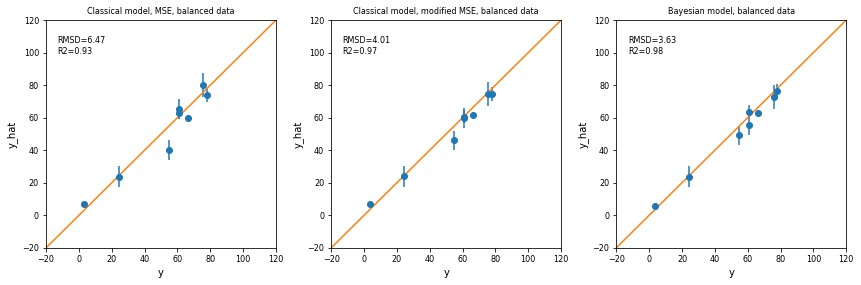

In [99]:
# data to tensor
X_test = torch.tensor(X_test)
y_test = torch.tensor(y_test)
stdev_test = stdev_test

# predict
yhat_classical = linear_reg_model_classical(X_test).detach().cpu().numpy().ravel()
yhat_errors = linear_reg_model_errors(X_test).detach().cpu().numpy().ravel()
yhat_bayes = bayesian_model.predict(X_test)

# calculate rmsd and r2
rmsd_classical = mean_squared_error(y_true=y_test, y_pred=yhat_classical, sample_weight=None, squared=False)
r2_classical = r2_score(y_true=y_test, y_pred=yhat_classical, sample_weight=None)

rmsd_errors = mean_squared_error(y_true=y_test, y_pred=yhat_errors, sample_weight=None, squared=False)
r2_errors = r2_score(y_true=y_test, y_pred=yhat_errors, sample_weight=None)

rmsd_bayes = mean_squared_error(y_true=y_test, y_pred=yhat_bayes, sample_weight=None, squared=False)
r2_bayes = r2_score(y_true=y_test, y_pred=yhat_bayes, sample_weight=None)

# plot the predictions
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), sharey=False)

ax[0].errorbar(y_test.numpy(), yhat_classical, yerr=stdev_test, fmt="o")
ax[0].plot([0, 1], [0, 1], transform=ax[0].transAxes)
ax[0].text(x=0.05, y=0.90, s='RMSD={:.2f}'.format(rmsd_classical), transform=ax[0].transAxes)
ax[0].text(x=0.05, y=0.85, s='R2={:.2f}'.format(r2_classical), transform=ax[0].transAxes)
ax[0].set(xlabel="y",
          ylabel="y_hat",
          title="Classical model, MSE, balanced data",
          xlim=(-20, 120),
          ylim=(-20, 120))

ax[1].errorbar(y_test.numpy(), yhat_errors, yerr=stdev_test, fmt="o")
ax[1].plot([0, 1], [0, 1], transform=ax[1].transAxes)
ax[1].text(x=0.05, y=0.90, s='RMSD={:.2f}'.format(rmsd_errors), transform=ax[1].transAxes)
ax[1].text(x=0.05, y=0.85, s='R2={:.2f}'.format(r2_errors), transform=ax[1].transAxes)
ax[1].set(xlabel="y",
          ylabel="y_hat",
          title="Classical model, modified MSE, balanced data",
          xlim=(-20, 120),
          ylim=(-20, 120))

ax[2].errorbar(y_test.numpy(), yhat_bayes, yerr=stdev_test, fmt="o")
ax[2].plot([0, 1], [0, 1], transform=ax[2].transAxes)
ax[2].text(x=0.05, y=0.90, s='RMSD={:.2f}'.format(rmsd_bayes), transform=ax[2].transAxes)
ax[2].text(x=0.05, y=0.85, s='R2={:.2f}'.format(r2_bayes), transform=ax[2].transAxes)
ax[2].set(xlabel="y",
          ylabel="y_hat",
          title="Bayesian model, balanced data",
          xlim=(-20, 120),
          ylim=(-20, 120))

plt.tight_layout()
plt.show()

Observations: The classical linear models with MSE performs the worst, fixing MSE to take measurement error into account alrady improves the model very significantly, but a full Bayesian treatment of the problem gives the best result. Pretty cool!

# Incorporating weighting of samples
Oftentimes the datasets are skewed and many more samples exist from one part of the distribution than from other parts. Here I want to modify the loss functions so that I can pass a weight parameter (between 0.0 and 1.0) such that over-represented samples can be down-weighted to get a better overall fit of the model.

## Still TODO

In [ ]:
model.parameters()

In [ ]:
for p in guide.parameters():
    print(p)

**Setup a custom loss function to allow for adjusting importance of individual measurements**

In [ ]:
from torch.nn.parameter import Parameter, UninitializedParameter
from torch.nn.modules.module import Module

In [ ]:
# http://docs.pyro.ai/en/stable/_modules/pyro/infer/trace_elbo.html#Trace_ELBO.loss

from pyro.infer import Trace_ELBO
from pyro.infer.predictive import Predictive

predictions = Predictive(model, samples_4)(rng_key_,
                                                marriage=dset.MarriageScaled.values,
                                                age=dset.AgeScaled.values,
                                                divorce_sd=dset.DivorceScaledSD.values)['obs']

In [ ]:
# https://pyro.ai/examples/custom_objectives.html
import pyro.poutine as poutine

# note that simple_elbo takes a model, a guide, and their respective arguments as inputs
def simple_elbo(model, guide, *args, **kwargs):
    # run the guide and trace its execution
    guide_trace = poutine.trace(guide).get_trace(*args, **kwargs)
    
    # run the model and replay it against the samples from the guide
    model_trace = poutine.trace(
        poutine.replay(model, trace=guide_trace)).get_trace(*args, **kwargs)
    
    # construct the elbo loss function
    return -1*(model_trace.log_prob_sum() - guide_trace.log_prob_sum())


In [ ]:
# Clear all the parameter store
pyro.clear_param_store()

optimizer = ClippedAdam({"lr": 0.1})
svi = SVI(model=linear_model, guide=guide, optim=optimizer, loss=Trace_ELBO())

param_vals = []
optimization_steps = 50
for i in range(optimization_steps):

    loss = svi.step(X_train, y_train)

#     # store values for inspection later
#     param_vals.append({k: param(k).item() for k in ['alpha', 'beta']})
#     param_vals[-1]['loss'] = loss

In [ ]:
# Clear all the parameter store
pyro.clear_param_store()

svi = SVI(model=linear_model,
             guide=guide,
             optim=Adam({"lr": 0.001}),
             loss=Trace_ELBO())

for epoch in range(10):
    svi.step(X_train, y_train)

In [ ]:
# Clear all the parameter store
pyro.clear_param_store()


optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.90, 0.999))
criterion = Trace_ELBO()
# criterion = simple_elbo

for epoch in range(10):
    optimizer.zero_grad()
#     x = x.cuda()
    loss = criterion.differentiable_loss(model.model, model.guide, X_train, y_train)
#     loss = loss.sum()
    loss.backward()
    print(loss)
    optimizer.step()


In [ ]:
pyro.get_all_param_names()

In [ ]:
for p in linear_reg_model_errors.parameters():
    p
type(p)

In [ ]:
for p in guide.parameters():
    print(p)

In [ ]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
elbo_loss_fn = pyro.infer.Trace_ELBO.differentiable_loss
for epoch in range(1000):
    epoch_loss = 0.
    for x, _ in train_dl:
        x = x.cuda()
        loss = elbo_loss_fn(model=vae.model, guide=vae.guide)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
